# Library

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score


# DATASET

In [2]:
df = pd.read_excel('/kaggle/input/my-final-dl/dataraw1.xlsx')
df.head()

,Name,URL,Generated_URL,Genres
0,Frieren: Beyond Journey's End,https://cdn.anime-planet.com/anime/primary/fri...,https://www.anime-planet.com/anime/frieren-bey...,"Adventure, Fantasy, Shounen"
1,The Apothecary Diaries,https://cdn.anime-planet.com/anime/primary/the...,https://www.anime-planet.com/anime/the-apothec...,"Drama, Mystery, Slice of Life"
2,Fullmetal Alchemist: Brotherhood,https://cdn.anime-planet.com/anime/primary/ful...,https://www.anime-planet.com/anime/fullmetal-a...,"Action, Adventure, Drama"
3,Mo Dao Zu Shi 3,https://cdn.anime-planet.com/anime/primary/mo-...,https://www.anime-planet.com/anime/mo-dao-zu-s...,"Action, Adventure, Fantasy"
4,Demon Slayer: Kimetsu no Yaiba - Entertainment...,https://cdn.anime-planet.com/anime/primary/dem...,https://www.anime-planet.com/anime/demon-slaye...,"Action, Adventure, Shounen"


# PROCESSING

In [3]:
# Tạo cột image_path
def get_image_path(row):
    name = row['Name']  # Lấy tên anime từ cột Name
    sanitized_name = ''.join(c if c.isalnum() else '_' for c in name)  # Thay ký tự đặc biệt bằng '_'
    return f"/kaggle/input/my-final-dl/downloaded_images_preprocessing/downloaded_images/{sanitized_name}.png"

# Áp dụng hàm để tạo cột image_path
df['image_path'] = df.apply(get_image_path, axis=1)

In [4]:
# so sánh tên ảnh trong folder với tên ảnh trong file excel, nếu không trùng thì xoá luôn các dòng đó
for index, row in df.iterrows():
    image_path = row['image_path']
    if not os.path.exists(image_path):
        # print(f"Removing row with missing image: {image_path}")
        df.drop(index, inplace=True)

df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 8063
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           7344 non-null   object
 1   URL            7344 non-null   object
 2   Generated_URL  7344 non-null   object
 3   Genres         7344 non-null   object
 4   image_path     7344 non-null   object
dtypes: object(5)
memory usage: 344.2+ KB


In [6]:
# Bước 1: Chuyển genres thành danh sách
df['Genres_list'] = df['Genres'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Chọn 4 thể loại phổ biến nhất
top_genres = ['Action', 'Comedy', 'Fantasy', 'Drama']

# Cập nhật cột multi-label chỉ giữ lại 4 thể loại này
def filter_labels(genres, top_genres):
    return [1 if genre in genres else 0 for genre in top_genres]

df['Filtered_labels'] = df['Genres_list'].apply(lambda x: filter_labels(x, top_genres))
print(df[['Genres_list', 'Filtered_labels']].head())

                       Genres_list Filtered_labels
0    [Adventure, Fantasy, Shounen]    [0, 0, 1, 0]
1  [Drama, Mystery, Slice of Life]    [0, 0, 0, 1]
2       [Action, Adventure, Drama]    [1, 0, 0, 1]
3     [Action, Adventure, Fantasy]    [1, 0, 1, 0]
4     [Action, Adventure, Shounen]    [1, 0, 0, 0]


In [7]:
df['Filtered_labels'] = df['Genres_list'].apply(lambda x: filter_labels(x, top_genres))

# Lọc bỏ các anime không có thể loại thuộc top_genres
df = df[df['Filtered_labels'].apply(lambda x: any(x))]

In [8]:
# Thông số
img_size = (224, 224)  # Kích thước ảnh
classes = ['Action', 'Comedy', 'Fantasy', 'Drama']  # Danh sách thể loại

# Đọc dữ liệu từ DataFrame
images = []
labels = []

for _, row in df.iterrows():
    # Load ảnh
    img_path = row['image_path']
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Chuẩn hóa về [0, 1]
    images.append(img_array)

    # Chuyển nhãn thành multi-hot encoding
    genre_list = row['Genres_list']
    label_vector = [1 if genre in genre_list else 0 for genre in classes]
    labels.append(label_vector)

# Chuyển đổi sang numpy array
x = np.array(images)
y = np.array(labels)

# Chia tập train/val
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
print("Kích thước x_train:", x_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước x_val:", x_val.shape)
print("Kích thước y_val:", y_val.shape)


Kích thước x_train: (4130, 224, 224, 3)
Kích thước y_train: (4130, 4)
Kích thước x_val: (1033, 224, 224, 3)
Kích thước y_val: (1033, 4)


In [10]:
x_train

array([[[[0.03137255, 0.03137255, 0.03137255],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.03137255, 0.03137255, 0.03137255],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        [[0.03137255, 0.03137255, 0.03137255],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784],
         [0.01960784, 0.01960784, 0.01960784]],

        ...,

        [[0.6862745 , 0.6862745 , 0.6862745 ],
         [1.        , 1.        , 1.        ]

In [11]:
y_train

array([[1, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 1, 1],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

# TĂNG CƯỜNG DATA

In [12]:
class_counts = np.sum(y_train, axis=0)  # Tính tổng số mẫu cho mỗi lớp
print(class_counts)  # In ra số lượng mẫu của từng thể loại

[1761 1587 1354 1040]


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def multilabel_balanced_augmentation(x_train, y_train, classes, target_samples_per_class):
    data_gen = ImageDataGenerator(
        # rotation_range=20,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        zoom_range=0.2,
        # horizontal_flip=True,
        # fill_mode='nearest'
    )
    
    # Lưu lại các mẫu gốc
    x_final = list(x_train)
    y_final = list(y_train)
    
    # Tính số lượng mẫu hiện tại cho mỗi lớp
    current_samples = np.sum(y_train, axis=0)
    print("Số lượng mẫu ban đầu cho mỗi lớp:")
    for i, count in enumerate(current_samples):
        print(f"{classes[i]}: {count}")
    
    # Tìm các lớp cần tăng cường
    for class_idx in range(len(classes)):
        if current_samples[class_idx] < target_samples_per_class:
            samples_needed = target_samples_per_class - current_samples[class_idx]
            print(f"\nĐang tăng cường lớp {classes[class_idx]}")
            print(f"Cần thêm {samples_needed} mẫu")
            
            valid_indices = []
            for i in range(len(y_train)):
                if y_train[i][class_idx] == 1:
                    is_valid = True
                    for other_class in range(len(classes)):
                        if (other_class != class_idx and 
                            y_train[i][other_class] == 1 and 
                            current_samples[other_class] >= target_samples_per_class):
                            is_valid = False
                            break
                    if is_valid:
                        valid_indices.append(i)
            
            if not valid_indices:
                print(f"Không tìm thấy mẫu phù hợp để tăng cường cho lớp {classes[class_idx]}")
                continue
            
            # Tăng cường dữ liệu
            augmented_count = 0
            while augmented_count < samples_needed and valid_indices:
                idx = np.random.choice(valid_indices)
                img = x_train[idx]
                label = y_train[idx]
                
                img_reshaped = img.reshape((1,) + img.shape)
                aug_img = data_gen.random_transform(img)
                
                x_final.append(aug_img)
                y_final.append(label)
                
                for i in range(len(classes)):
                    if label[i] == 1:
                        current_samples[i] += 1
                
                augmented_count += 1
            
            print(f"Đã tăng cường {augmented_count} mẫu cho lớp {classes[class_idx]}")
    
    x_final = np.array(x_final)
    y_final = np.array(y_final)
    
    # Trộn dữ liệu
    indices = np.random.permutation(len(x_final))
    x_final = x_final[indices]
    y_final = y_final[indices]
    
    return x_final, y_final

def print_class_stats(y, classes):
    """In thống kê chi tiết về số lượng mẫu cho mỗi lớp"""
    print("\nThống kê số lượng mẫu cho mỗi lớp:")
    class_counts = np.sum(y, axis=0)
    for idx, count in enumerate(class_counts):
        print(f"Class {classes[idx]}: {count} samples")
    
    print("\nPhân tích mẫu multi-label:")
    label_counts = np.sum(y, axis=1)
    for i in range(1, max(label_counts) + 1):
        count = np.sum(label_counts == i)
        print(f"Số mẫu thuộc {i} lớp: {count}")
# Thiết lập số lượng mẫu mục tiêu cho mỗi lớp
target_samples = 2000

# Cân bằng dữ liệu
x_balanced, y_balanced = multilabel_balanced_augmentation(
    x_train, 
    y_train, 
    classes, 
    target_samples
)

# In thống kê chi tiết
print_class_stats(y_balanced, classes)

Số lượng mẫu ban đầu cho mỗi lớp:
Action: 1761
Comedy: 1587
Fantasy: 1354
Drama: 1040

Đang tăng cường lớp Action
Cần thêm 239 mẫu
Đã tăng cường 239 mẫu cho lớp Action

Đang tăng cường lớp Comedy
Cần thêm 372 mẫu
Đã tăng cường 372 mẫu cho lớp Comedy

Đang tăng cường lớp Fantasy
Cần thêm 502 mẫu
Đã tăng cường 502 mẫu cho lớp Fantasy

Đang tăng cường lớp Drama
Cần thêm 801 mẫu
Đã tăng cường 801 mẫu cho lớp Drama

Thống kê số lượng mẫu cho mỗi lớp:
Class Action: 2000 samples
Class Comedy: 2000 samples
Class Fantasy: 2000 samples
Class Drama: 2000 samples

Phân tích mẫu multi-label:
Số mẫu thuộc 1 lớp: 4242
Số mẫu thuộc 2 lớp: 1648
Số mẫu thuộc 3 lớp: 154


In [14]:
# # Thiết lập số lượng mẫu mục tiêu cho mỗi lớp
# target_samples = 1500

# # Cân bằng dữ liệu
# x_val_balanced, y_val_balanced = multilabel_balanced_augmentation(
#     x_val, 
#     y_val, 
#     classes, 
#     target_samples
# )

# # In thống kê chi tiết
# print_class_stats(y_val_balanced, classes)

In [15]:
print(x_balanced.shape)

(6044, 224, 224, 3)


# VISUAL

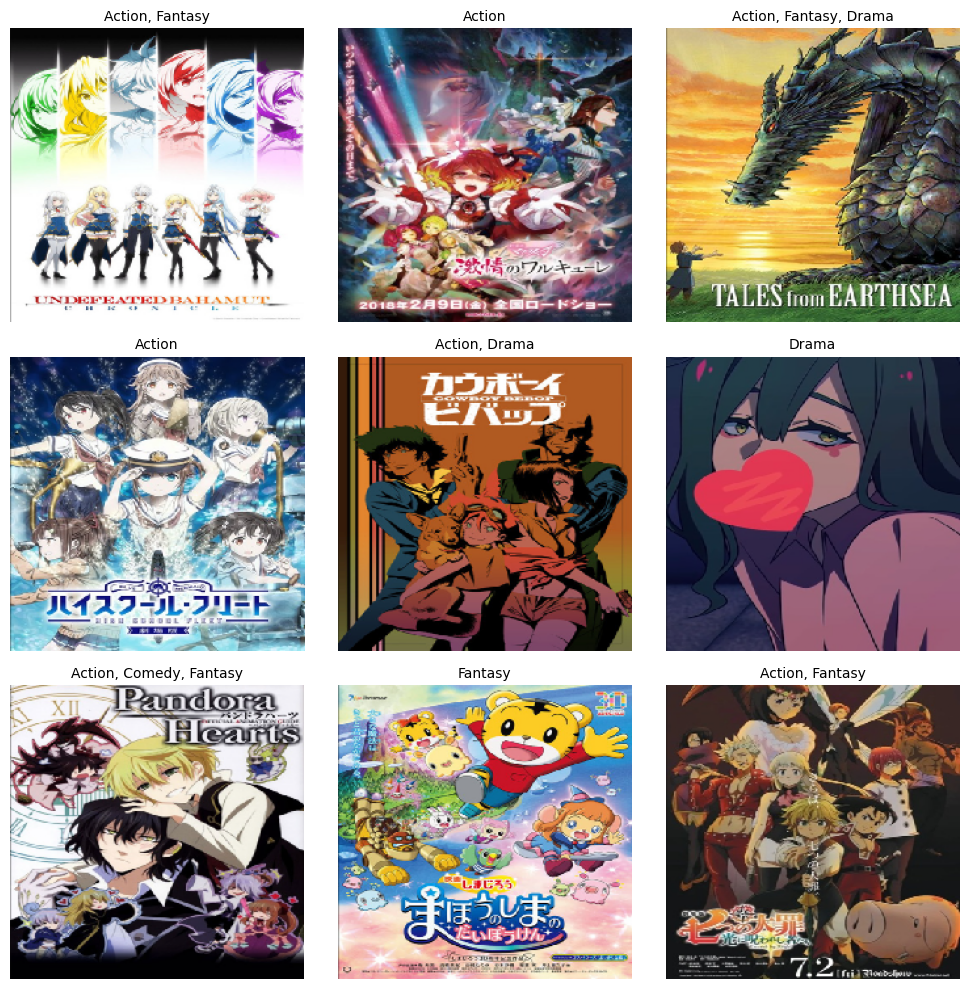

In [16]:
# Hiển thị 9 hình ảnh mẫu từ tập x_train
def plot_sample_images(x_data, y_data, classes, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_data[i])  # Hiển thị ảnh
        plt.axis('off')  # Tắt trục
        # Lấy nhãn và hiển thị các thể loại
        genres = [classes[idx] for idx, value in enumerate(y_data[i]) if value == 1]
        plt.title(", ".join(genres), fontsize=10)
    plt.tight_layout()
    plt.show()

plot_sample_images(x_train, y_train, classes)

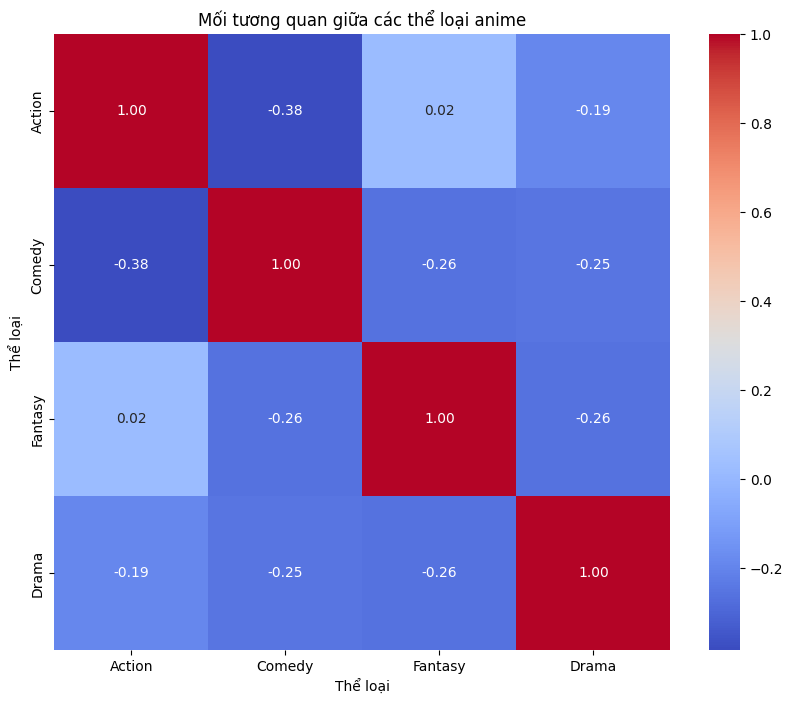

In [17]:
# Chuyển nhãn sang DataFrame để tiện tính toán
labels_df = pd.DataFrame(y, columns=classes)

# Tính ma trận tương quan giữa các thể loại
correlation_matrix = labels_df.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Mối tương quan giữa các thể loại anime')
plt.xlabel('Thể loại')
plt.ylabel('Thể loại')
plt.show()


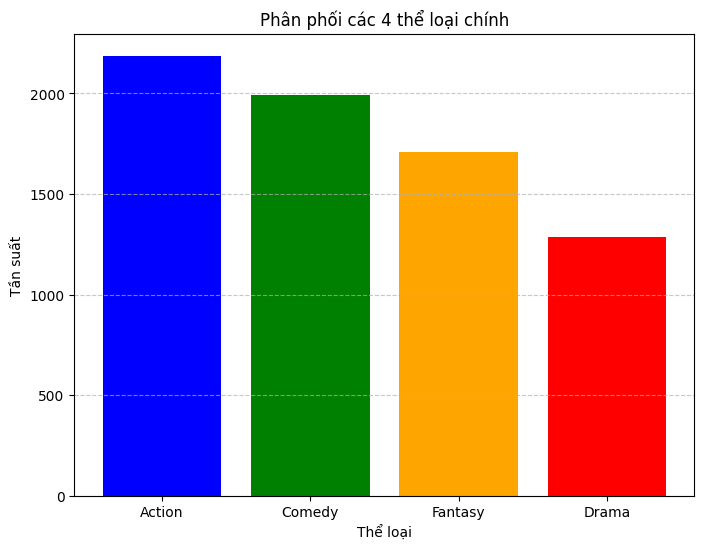

In [18]:
# Tính tần suất của từng thể loại
genre_counts = np.sum(y, axis=0)

# Bar plot cho phân phối thể loại
plt.figure(figsize=(8, 6))
plt.bar(classes, genre_counts, color=['blue', 'green', 'orange', 'red'])
plt.title('Phân phối các 4 thể loại chính')
plt.xlabel('Thể loại')
plt.ylabel('Tần suất')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


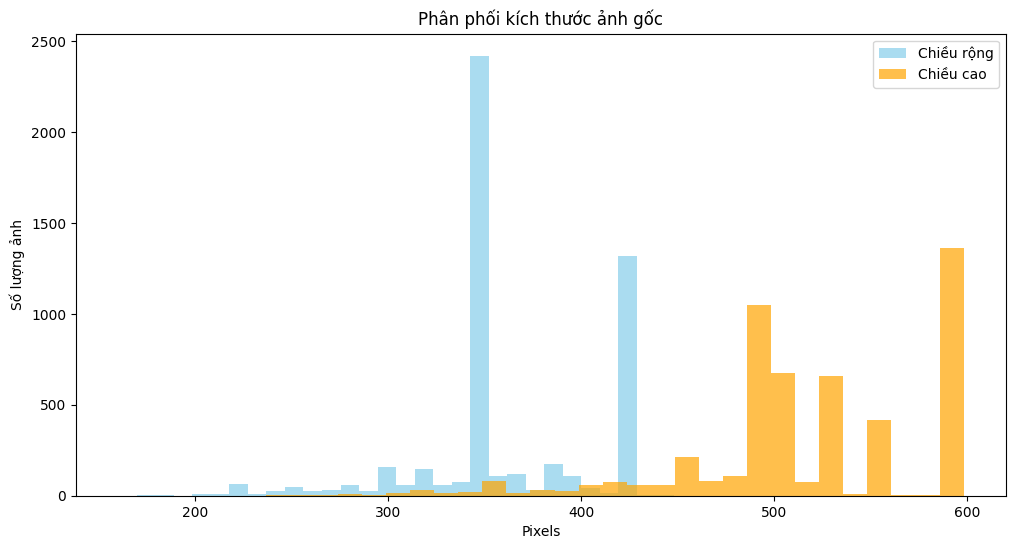

In [19]:
# Lấy kích thước của tất cả các ảnh
original_sizes = [load_img(row['image_path']).size for _, row in df.iterrows()]

# Tách chiều rộng và chiều cao
widths, heights = zip(*original_sizes)

# Vẽ histogram cho chiều rộng và chiều cao
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=30, color='skyblue', alpha=0.7, label='Chiều rộng')
plt.hist(heights, bins=30, color='orange', alpha=0.7, label='Chiều cao')
plt.title('Phân phối kích thước ảnh gốc')
plt.xlabel('Pixels')
plt.ylabel('Số lượng ảnh')
plt.legend()
plt.show()


# Model

# VGG19

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [21]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [22]:
# Load mô hình VGG19 pre-trained
base_model = VGG19(
    include_top=False,  # Loại bỏ lớp fully connected gốc của VGG19
    weights='imagenet', # Sử dụng trọng số ImageNet
    input_shape=(224, 224, 3)  # Kích thước ảnh đầu vào
)

# Đóng băng các lớp của base_model để không huấn luyện lại
# base_model.trainable = False
# Mở khóa một số lớp phía trên của VGG19
for layer in base_model.layers[:10]:  # Đóng băng 5 lớp đầu
    layer.trainable = True
    
# Thêm các lớp phía trên
x = base_model.output
x = Flatten()(x)  # Làm phẳng output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout để tránh overfitting
output = Dense(len(classes), activation='sigmoid')(x)  # Output layer cho multi-label

# Khởi tạo model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate nhỏ để fine-tuning
    loss='binary_crossentropy',           # Multi-label binary crossentropy
    metrics=['accuracy']
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
# Early stopping để tránh overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Huấn luyện mô hình
history2 = model.fit(
    # x_train, 
    # y_train,
    # data_gen.flow(x_train, y_train),
    data_gen.flow(x_balanced, y_balanced),
    validation_data=(data_gen.flow(x_val, y_val)),
    batch_size=32,  # Thử nghiệm với batch size phù hợp với GPU
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733224507.290882      97 service.cc:145] XLA service 0x780a6c004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733224507.290965      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733224528.542399      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 114s 457ms/step - accuracy: 0.3082 - loss: 0.6679 - val_accuracy: 0.5499 - val_loss: 0.5808
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 351ms/step - accuracy: 0.4531 - loss: 0.5845 - val_accuracy: 0.5431 - val_loss: 0.5646
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.5221 - loss: 0.5562 - val_accuracy: 0.4579 - val_loss: 0.6171
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.5243 - loss: 0.5512 - val_accuracy: 0.5586 - val_loss: 0.5502
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step - accuracy: 0.5510 - loss: 0.5317 - val_accuracy: 0.5247 - val_loss: 0.5614
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.5549 - loss: 0.5191 - val_accuracy: 0.5557 - val_loss: 0.5549
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.5719 - loss: 0.5035 - val_accuracy: 0.4753 - val_loss: 0.5813
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step - accuracy: 0.6018 - loss: 0.4865 - va

In [24]:
# Đánh giá trên tập validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5888 - loss: 0.5405
Validation Loss: 0.5392
Validation Accuracy: 0.6002


In [25]:
# Tạo dự đoán trên tập validation
y_val_pred = model.predict(x_val)  # Dự đoán xác suất
y_val_pred_labels = (y_val_pred > 0.5).astype(int)  # Chuyển đổi thành nhãn 0 hoặc 1

# In báo cáo chi tiết (Precision, Recall, F1 Score) theo từng lớp
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred_labels, target_names=classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Validation Metrics:
              precision    recall  f1-score   support

      Action       0.66      0.80      0.72       427
      Comedy       0.65      0.66      0.66       404
     Fantasy       0.63      0.27      0.38       357
       Drama       0.54      0.18      0.27       247

   micro avg       0.64      0.52      0.58      1435
   macro avg       0.62      0.48      0.51      1435
weighted avg       0.63      0.52      0.54      1435
 samples avg       0.61      0.54      0.55      1435



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


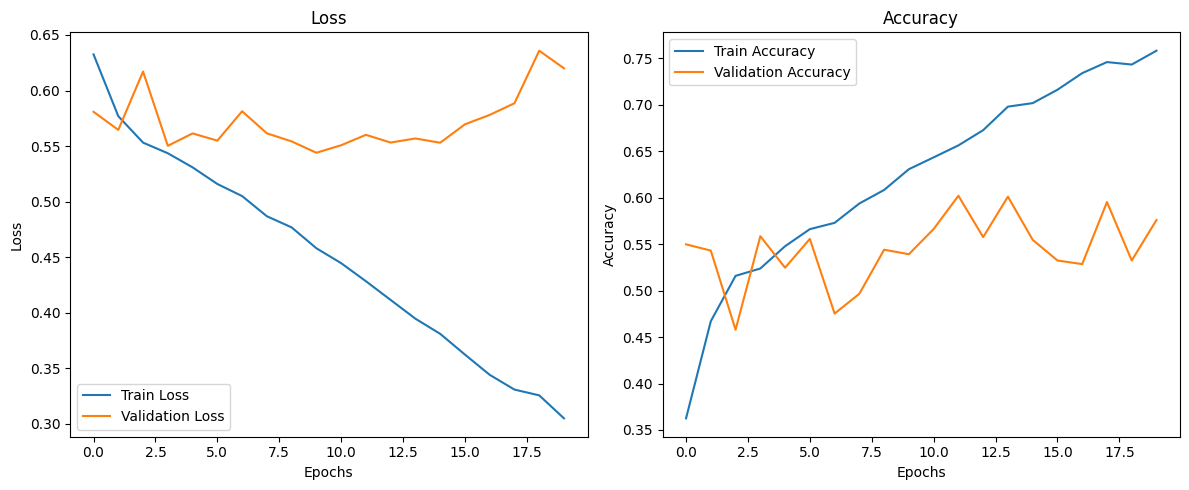

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Biểu đồ Loss
plt.subplot(1, 2, 1)  
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2) 
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hiển thị
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


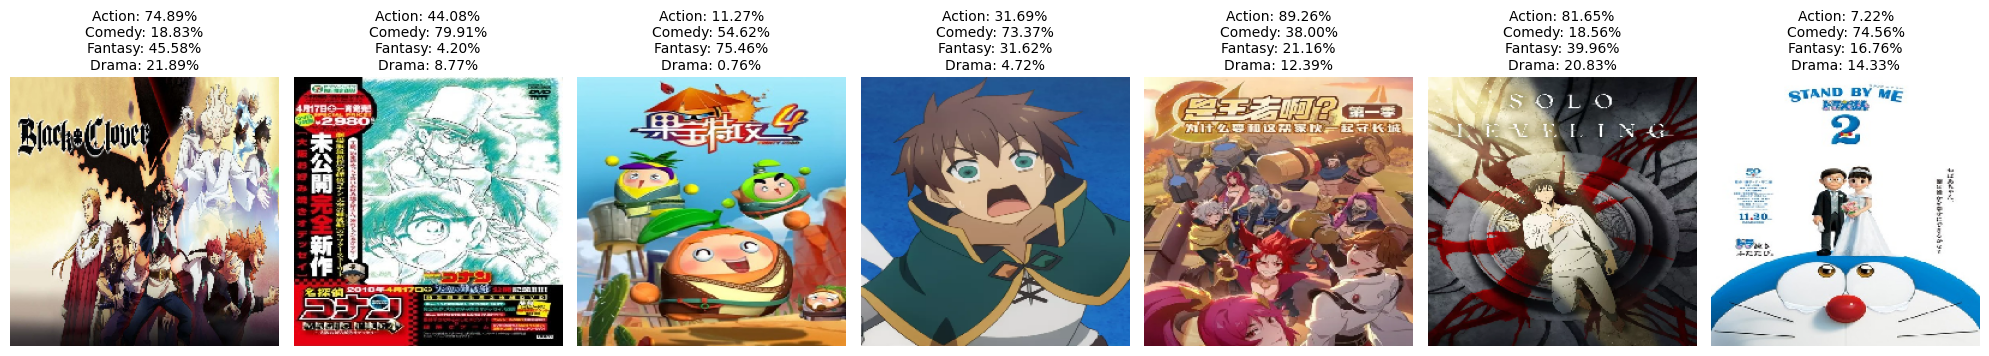

In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Danh sách các ảnh cần dự đoán
test_images_paths = [
    '/kaggle/input/test-dl/test_data/black-clover.jpg',
    '/kaggle/input/test-dl/test_data/detective-conan-magic-file-4-1.png',
    '/kaggle/input/test-dl/test_data/guobao-te-gong-4th-season-1-comedy.jpg',
    '/kaggle/input/test-dl/test_data/konosuba-gods-blessing-on-this-wonderful-world-3-ova-1-comedy.png',
    '/kaggle/input/test-dl/test_data/shi-wangzhe-a-1-fantasy.png',
    '/kaggle/input/test-dl/test_data/solo-leveling-reawakening-1.png',
    '/kaggle/input/test-dl/test_data/stand-by-me-doraemon-2-1-comedy-drama.jpg'
]

# Đọc và tiền xử lý ảnh
def preprocess_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Chuẩn hóa về [0, 1]
    return np.expand_dims(img_array, axis=0), img  # Trả về cả ảnh gốc và ảnh đã xử lý

# Dự đoán cho tất cả các ảnh
def predict_images(model, image_paths):
    predictions = []
    images = []
    for image_path in image_paths:
        processed_image, original_image = preprocess_image(image_path)
        pred = model.predict(processed_image)
        predictions.append(pred[0])  # Lưu xác suất dự đoán
        images.append(np.array(original_image))  # Chuyển ảnh gốc sang mảng NumPy
    return predictions, images

# Tải mô hình đã huấn luyện
# model = tf.keras.models.load_model('path_to_saved_model')

# Dự đoán và lấy ảnh
predictions, images = predict_images(model, test_images_paths)

# Hiển thị ảnh và kết quả dự đoán
plt.figure(figsize=(20, 5))
for i, (pred_probs, image) in enumerate(zip(predictions, images)):
    plt.subplot(1, len(test_images_paths), i + 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    title = "\n".join([f"{label}: {prob * 100:.2f}%" for label, prob in zip(classes, pred_probs)])
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()

In [28]:
# Lưu mô hình vào thư mục hiện tại (mặc định là /kaggle/working)
model.save('/kaggle/working/vgg19_model2.h5')
print("Mô hình đã được lưu thành công!")

Mô hình đã được lưu thành công!


 # InceptionV3 pre-trained với Transfer Learning

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Tạo mô hình InceptionV3 pre-trained
base_model = InceptionV3(
    include_top=False,  # Không sử dụng các lớp fully connected mặc định của InceptionV3
    weights='imagenet',  # Sử dụng trọng số pre-trained từ ImageNet
    input_shape=(224, 224, 3)  # Kích thước ảnh đầu vào
)

# Đóng băng các lớp của base_model (các lớp gốc không thay đổi)
for layer in base_model.layers[:10]:  # Đóng băng 10 lớp đầu
    layer.trainable = True

# Thêm các lớp fully connected
x = base_model.output
x = Flatten()(x)  # Làm phẳng output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout để tránh overfitting
output = Dense(len(classes), activation='sigmoid')(x)  # Output layer cho multi-label

# Khởi tạo mô hình
model2 = Model(inputs=base_model.input, outputs=output)

# Compile mô hình
model2.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate nhỏ để fine-tuning
    loss='binary_crossentropy',  # Binary crossentropy cho multi-label classification
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Early stopping để tránh overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Huấn luyện mô hình với dữ liệu đã tăng cường
history3 = model2.fit(
    # data_gen.flow(x_train, y_train, batch_size=32),
    # validation_data=(x_val, y_val),
    data_gen.flow(x_balanced, y_balanced),
    validation_data=(data_gen.flow(x_val, y_val)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 176s 570ms/step - accuracy: 0.3080 - loss: 0.7018 - val_accuracy: 0.4124 - val_loss: 0.6116
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.3881 - loss: 0.6074 - val_accuracy: 0.4966 - val_loss: 0.5784
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.4343 - loss: 0.5918 - val_accuracy: 0.5073 - val_loss: 0.5733
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 344ms/step - accuracy: 0.4665 - loss: 0.5743 - val_accuracy: 0.5082 - val_loss: 0.5791
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 341ms/step - accuracy: 0.4962 - loss: 0.5556 - val_accuracy: 0.4985 - val_loss: 0.5617
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 342ms/step - accuracy: 0.5058 - loss: 0.5459 - val_accuracy: 0.5615 - val_loss: 0.5541
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 341ms/step - accuracy: 0.5246 - loss: 0.5368 - val_accuracy: 0.5208 - val_loss: 0.5596
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 66s 340ms/step - accuracy: 0.5458 - loss: 0.5245 - va

In [ ]:
# Đánh giá trên tập validation
val_loss, val_accuracy = model2.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
# Tạo dự đoán trên tập validation
y_val_pred = model2.predict(x_val)  # Dự đoán xác suất
y_val_pred_labels = (y_val_pred > 0.5).astype(int)  # Chuyển đổi thành nhãn 0 hoặc 1

# In báo cáo chi tiết (Precision, Recall, F1 Score) theo từng lớp
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred_labels, target_names=classes))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Biểu đồ Loss
plt.subplot(1, 2, 1)  
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2) 
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hiển thị
plt.tight_layout()
plt.show()


In [ ]:
# Danh sách các ảnh cần dự đoán
test_images_paths = [
    '/kaggle/input/test-dl/test_data/black-clover.jpg',
    '/kaggle/input/test-dl/test_data/detective-conan-magic-file-4-1.png',
    '/kaggle/input/test-dl/test_data/guobao-te-gong-4th-season-1-comedy.jpg',
    '/kaggle/input/test-dl/test_data/konosuba-gods-blessing-on-this-wonderful-world-3-ova-1-comedy.png',
    '/kaggle/input/test-dl/test_data/shi-wangzhe-a-1-fantasy.png',
    '/kaggle/input/test-dl/test_data/solo-leveling-reawakening-1.png',
    '/kaggle/input/test-dl/test_data/stand-by-me-doraemon-2-1-comedy-drama.jpg'
]

# Đọc và tiền xử lý ảnh
def preprocess_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Chuẩn hóa về [0, 1]
    return np.expand_dims(img_array, axis=0), img  # Trả về cả ảnh gốc và ảnh đã xử lý

# Dự đoán cho tất cả các ảnh
def predict_images(model, image_paths):
    predictions = []
    images = []
    for image_path in image_paths:
        processed_image, original_image = preprocess_image(image_path)
        pred = model.predict(processed_image)
        predictions.append(pred[0])  # Lưu xác suất dự đoán
        images.append(np.array(original_image))  # Chuyển ảnh gốc sang mảng NumPy
    return predictions, images

# Dự đoán và lấy ảnh sử dụng `model2`
predictions2, images2 = predict_images(model2, test_images_paths)

# Hiển thị ảnh và kết quả dự đoán từ `model2`
plt.figure(figsize=(20, 5))  # Điều chỉnh chiều rộng để phù hợp số lượng ảnh
for i, (pred_probs, image) in enumerate(zip(predictions2, images2)):
    plt.subplot(1, len(test_images_paths), i + 1)  # Tất cả ảnh trên cùng một hàng
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    title = "\n".join([f"{label}: {prob * 100:.2f}%" for label, prob in zip(classes, pred_probs)])
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Lưu mô hình vào thư mục hiện tại (mặc định là /kaggle/working)
model2.save('/kaggle/working/Inception_model2.h5')
print("Mô hình đã được lưu thành công!")

# SO SÁNH CÁC MODEL

THỜI GIAN XỬ LÝ

In [ ]:
# import time

# # Tính thời gian chạy cho mỗi mô hình
# start_time1 = time.time()
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# end_time1 = time.time()
# time_taken1 = end_time1 - start_time1

# start_time2 = time.time()
# history1 = model1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# end_time2 = time.time()
# time_taken2 = end_time2 - start_time2

# start_time3 = time.time()
# history2 = model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# end_time3 = time.time()
# time_taken3 = end_time3 - start_time3

ACCURACY & LOSS

In [ ]:
# # So sánh độ chính xác 
# labels = ['CNN', 'CNN + FOCAL LOSS', 'RESNET50']
# train_accuracies = [train_accuracy[-1], train_accuracy1[-1], train_accuracy2[-1]]
# val_accuracies = [val_accuracy[-1], val_accuracy1[-1], val_accuracy2[-1]]

# # Vẽ biểu đồ Accuracy
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Accuracy
# axes[0].bar(labels, train_accuracies, width=0.4, label='Train Accuracy', align='center')
# axes[0].bar(labels, val_accuracies, width=0.4, label='Validation Accuracy', align='edge')
# axes[0].set_title('Comparison of Accuracy')
# axes[0].set_ylabel('Accuracy')
# axes[0].legend()

# # So sánh độ mất mát (loss)
# train_losses = [train_loss[-1], train_loss1[-1], train_loss2[-1]]
# val_losses = [val_loss[-1], val_loss1[-1], val_loss2[-1]]

# # Loss
# axes[1].bar(labels, train_losses, width=0.4, label='Train Loss', align='center')
# axes[1].bar(labels, val_losses, width=0.4, label='Validation Loss', align='edge')
# axes[1].set_title('Comparison of Loss')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# plt.tight_layout()
# plt.show()